<a href="https://colab.research.google.com/github/amura/xray-machinelearning/blob/TransferLearningResnet50/Transfer_learning_resnet50_ctscans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 16 05:57:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data setup

In [4]:
# setup drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

# RESNET50

In [6]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/gdrive/MyDrive/dicom/ctscans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/gdrive/MyDrive/dicom/covid/c_0.dcm,1
1,1,/content/gdrive/MyDrive/dicom/covid/c_1.dcm,1
2,2,/content/gdrive/MyDrive/dicom/covid/c_2.dcm,1
3,3,/content/gdrive/MyDrive/dicom/covid/c_3.dcm,1
4,4,/content/gdrive/MyDrive/dicom/covid/c_4.dcm,1


In [7]:
from sklearn.model_selection import train_test_split
# split data 20% test

train_set, test_set = train_test_split(data, test_size=0.2)

In [8]:
# Data augmentation
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True,  validation_split = 0.2)

validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                              validation_split = 0.2)

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [9]:
# install pydicom
!pip install pydicom

     |████████████████████████████████| 1.9MB 15.4MB/s 


In [10]:
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import pydicom

#DICOM image reader
# https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(224, 224), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

        return image_array

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
class_mode = 'binary'
colour_mode = 'rgb'
seed = 1234
num_epochs = 30

train_consts = {
    'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'training'
}

valid_consts = {
   'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width), 
    'shuffle': False
}

train_generator = DCMDataFrameIterator(dataframe=train_set,
                             x_col='paths',
                             y_col='label',                      
                             image_data_generator=train_datagen,
                             **train_consts)

validation_generator = DCMDataFrameIterator(dataframe=train_set,
                            x_col='paths',
                             y_col='label',                            
                             image_data_generator=validation_datagen,
                             **valid_consts)



Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


### Configure model

In [12]:
from keras.applications.resnet50 import ResNet50
resnet50BaseModel = ResNet50(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))
resnet50BaseModel.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [13]:
# setup classification layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
# freeze the top layers
resnet50BaseModel.trainable = False


#configure the classification layer 
model = keras.Sequential([
  resnet50BaseModel,
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),
  layers.Dense(2, activation='softmax')                          
])

In [14]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import optimizers 

#create folder for storing results
if not os.path.exists('/content/gdrive/MyDrive/c19'): 
    print("Creating model folder") 
    os.makedirs('/content/gdrive/MyDrive/c19')

checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/c19/resnet50.hdf5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

time_callback = TimeHistory()


callbacks = [checkpoint, reduce_lr, time_callback]

 
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=['acc'])

number trainable weights 6


In [16]:
%%time 
history = model.fit(
	x=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=num_epochs,
  verbose=2,
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
  callbacks=callbacks
)
print("Timing summary", time_callback.times)


Epoch 1/30
15/15 - 258s - loss: 1.0638 - acc: 0.4780 - val_loss: 0.7584 - val_acc: 0.5378

Epoch 00001: val_acc improved from -inf to 0.53782, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
15/15 - 9s - loss: 0.8288 - acc: 0.5577 - val_loss: 0.6812 - val_acc: 0.6303

Epoch 00002: val_acc improved from 0.53782 to 0.63025, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 3/30
15/15 - 6s - loss: 0.7481 - acc: 0.6394 - val_loss: 0.6161 - val_acc: 0.6891

Epoch 00003: val_acc improved from 0.63025 to 0.68908, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 4/30
15/15 - 6s - loss: 0.6901 - acc: 0.6352 - val_loss: 0.5854 - val_acc: 0.7479

Epoch 00004: val_acc improved from 0.68908 to 0.74790, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 5/30
15/15 - 6s - loss: 0.6698 - acc: 0.6583 - val_loss: 0.5685 - val_acc: 0.7059

Epoch 00005: val_acc did not improve from 0.74790
Epoch 6/30
15/15 - 6s - loss: 0.6866 - acc: 0.6625 - val_loss: 0.5418 - val_acc: 0.7395

Epoch 00006: val_acc did not improve from 0.74790
Epoch 7/30
15/15 - 6s - loss: 0.6492 - acc: 0.6918 - val_loss: 0.5213 - val_acc: 0.7647

Epoch 00007: val_acc improv

### Training results

keys {'loss': [1.0637978315353394, 0.8287585973739624, 0.748100757598877, 0.6901366710662842, 0.6697518229484558, 0.686610996723175, 0.6492292284965515, 0.6582441329956055, 0.6336439847946167, 0.5858794450759888, 0.5990245342254639, 0.5397617816925049, 0.5642954111099243, 0.5301052331924438, 0.5792122483253479, 0.4957256615161896, 0.5405787229537964, 0.5245991945266724, 0.5089372396469116, 0.48684394359588623, 0.48729345202445984, 0.49234649538993835, 0.47378721833229065, 0.4375801980495453, 0.4670558273792267, 0.4257637858390808, 0.4724327325820923, 0.4712370038032532, 0.4609684348106384, 0.4675444960594177], 'acc': [0.4779874086380005, 0.5576519966125488, 0.6394129991531372, 0.6352201104164124, 0.6582809090614319, 0.6624737977981567, 0.6918238997459412, 0.6708595156669617, 0.6792452931404114, 0.7169811129570007, 0.696016788482666, 0.7400419116020203, 0.7358490824699402, 0.7379454970359802, 0.7169811129570007, 0.7735849022865295, 0.7589098811149597, 0.7463312149047852, 0.7589098811149

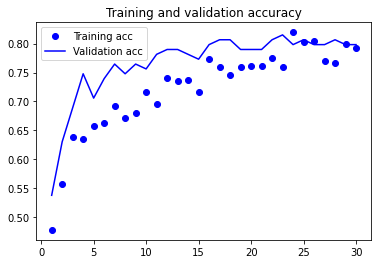

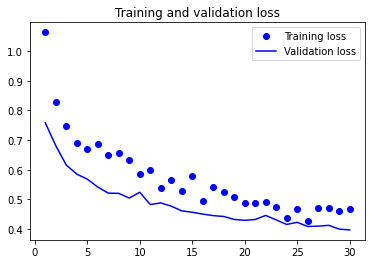

In [17]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# Using the testing generator to evaluate the model after training

test_generator = DCMDataFrameIterator(dataframe=test_set,
                             x_col='paths',
                             y_col='label',   
                             image_data_generator=test_datagen,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))


Found 150 validated image filenames belonging to 2 classes.
150/150 [==============================] - 79s 528ms/step - loss: 0.5204 - acc: 0.7600


In [20]:
# initialise the model and load the weigths from file
model = keras.Sequential([
  resnet50BaseModel,
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),
  layers.Dense(2, activation='softmax')                          
])

model.load_weights(filepath='/content/gdrive/MyDrive/c19/resnet50.hdf5')

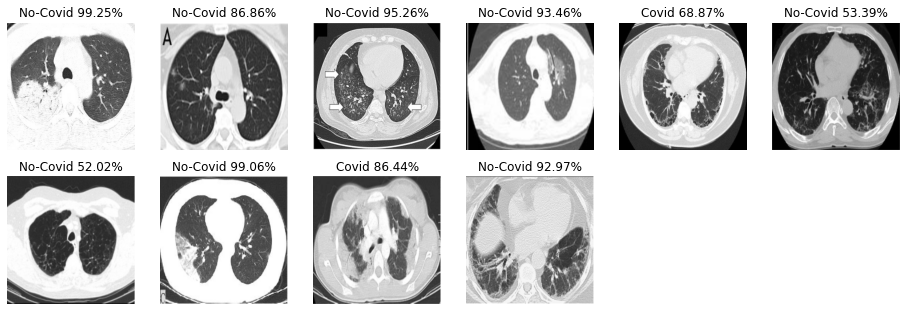

In [21]:
# show random results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for i in range(10):
    x, y = test_generator.next()
    prediction = model.predict(np.expand_dims(x[0], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[0])
# x, y = test_generator.next()

 